# Modelling and Evaluation Notebook

## Objectives

- Answer business requirement 2: 
    - The client is interested in predicting whether a potato leaf is healthy or diseased, and if diseased, identifying the specific disease present.


## Inputs

- inputs/leaves_dataset/leaf_images/train
- inputs/leaves_dataset/leaf_images/test
- inputs/leaves_dataset/leaf_images/validation
- image shape embeddings.

## Outputs
- Images distribution plot in train, validation, and test set.
- Image augmentation.
- Class indices to change prediction inference in labels.
- Machine learning model creation and training.
- Save model.
- Learning curve plot for model performance.
- Model evaluation on pickle file.
- Prediction on the random image file.

---

---

# Import regular packages

In [1]:
import os
import numpy as np
import tensorflow as tf
import random

os.environ['PYTHONHASHSEED'] = '0'
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread

---

# Set Working Directory

In [3]:
cwd= os.getcwd()

In [4]:
os.chdir(os.path.dirname(cwd))
print("You set a new current directory")

You set a new current directory


In [5]:
work_dir = os.getcwd()
work_dir

'c:\\Users\\jules\\Desktop\\coding\\potato-leaf-diseases'

---

## Set input directories

Set train, validation and test paths

In [6]:
my_data_dir = 'inputs/leaves_dataset/leaf_images'
train_path = my_data_dir + '/train'
val_path = my_data_dir + '/validation'
test_path = my_data_dir + '/test'

## Set output directory

In [7]:
version = 'v1'
file_path = f'outputs/{version}'

if 'outputs' in os.listdir(work_dir) and version in os.listdir(work_dir + '/outputs'):
    print('Old version is already available create a new version.')
    pass
else:
    os.makedirs(name=file_path)


Old version is already available create a new version.


## Set labels

In [8]:

labels = os.listdir(train_path)
n_labels = len(labels)

print(
    f"Project Labels: {labels}"
)


Project Labels: ['Bacteria', 'Healthy', 'Phytopthora']


## Set image shape

In [9]:
## Import saved image shape embedding
import joblib
version = 'v1'
image_shape = joblib.load(filename=f"outputs/{version}/image_shape.pkl")
image_shape

(300, 300, 3)

---

# Number of images in train, test and validation data

* train - Bacteria: 398 images
* train - Healthy: 140 images
* train - Phytopthora: 242 images
* validation - Bacteria: 56 images
* validation - Healthy: 20 images
* validation - Phytopthora: 34 images
* test - Bacteria: 115 images
* test - Healthy: 41 images
* test - Phytopthora: 71 images


          Set        Label  Frequency
0       train     Bacteria        398
1       train      Healthy        140
2       train  Phytopthora        242
3  validation     Bacteria         56
4  validation      Healthy         20
5  validation  Phytopthora         34
6        test     Bacteria        115
7        test      Healthy         41
8        test  Phytopthora         71




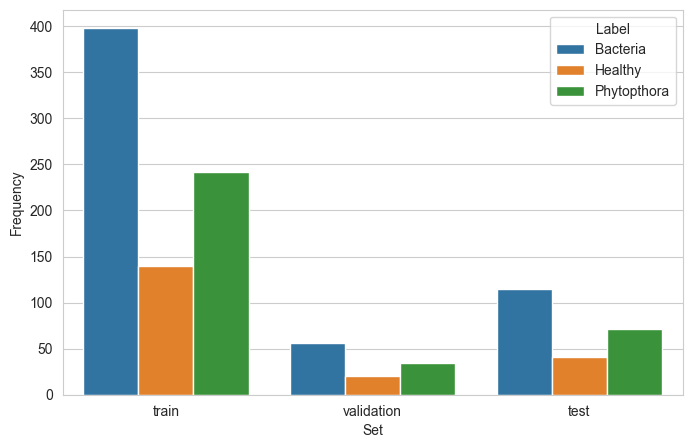

In [10]:
lst_freq = []
for folder in ['train', 'validation', 'test']:
    for label in labels:
        lst_freq.append(
            pd.Series(data={'Set': folder,
                            'Label': label,
                            'Frequency': int(len(os.listdir(my_data_dir + '/' + folder + '/' + label)))}
                      )
        )
        print(
            f"* {folder} - {label}: {len(os.listdir(my_data_dir+'/'+ folder + '/' + label))} images")
df_freq = pd.DataFrame(lst_freq)
print("\n")
print(df_freq)
print("\n")
sns.set_style("whitegrid")
plt.figure(figsize=(8, 5))
sns.barplot(data=df_freq, x='Set', y='Frequency', hue='Label')
plt.savefig(f'{file_path}/labels_distribution.png',
            bbox_inches='tight', dpi=150)
plt.show()


In [11]:
import shutil
import math
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def balance_sample_images(src_folder, dest_folder, target_count, label_folder):
    images = os.listdir(src_folder + '/' + label_folder)
    oversampleimggen = ImageDataGenerator(horizontal_flip=True,
                                          vertical_flip=True,
                                          fill_mode='nearest',
                                          )
    
    save_prefix = 'aug-'
    aug_gen=oversampleimggen.flow_from_directory(src_folder, batch_size=1, shuffle=True, seed=42, classes=[label_folder],
                                    save_to_dir=dest_folder, save_prefix=save_prefix, color_mode='rgb',
                                    save_format='jpg')
    print('Augmenting images for class:', label_folder)

    aug_img_count = 0
    while aug_img_count < target_count:
        save_prefix = 'aug-' + str(aug_img_count) + '-'
        image = next(aug_gen)
        aug_img_count += 1
    print('Total Augmented images created= ', aug_img_count)

In [12]:
import shutil
import math
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def balance_sample_images_min(src_folder, dest_folder, target_count, label_folder):
    images = os.listdir(src_folder + '/' + label_folder)
    oversampleimggen = ImageDataGenerator(horizontal_flip=True,
                                          vertical_flip=True
                                          )
    
    save_prefix = 'aug-'
    aug_gen=oversampleimggen.flow_from_directory(src_folder, batch_size=1, shuffle=True, seed=42, classes=[label_folder],
                                    save_to_dir=dest_folder, save_prefix=save_prefix, color_mode='rgb',
                                    save_format='jpg')
    print('Augmenting images for class:', label_folder)

    if len(images) < target_count:
        delta = target_count - len(images)
        aug_img_count = 0
        while aug_img_count < delta:
            save_prefix = 'aug-' + str(aug_img_count) + '-'
            image = next(aug_gen)
            aug_img_count += 1
        print('Total Augmented images created= ', aug_img_count)
        for i in range(len(images)):
            shutil.copy(src_folder + '/' + label_folder + '/' + images[i], dest_folder + '/' + images[i])
    else:
        for i in range(len(images)):
            shutil.copy(src_folder + '/' + label_folder + '/' + images[i], dest_folder + '/' + images[i])

In [13]:
train_balanced_path = my_data_dir + '/balanced/train_balanced'
if 'balanced' in os.listdir(work_dir + '/inputs/leaves_dataset/leaf_images'):
    shutil.rmtree(train_balanced_path)

os.makedirs(name=train_balanced_path)

label_folders = os.listdir(train_path)
avg_images = math.floor(sum(len(os.listdir(train_path + '/' + f)) for f in label_folders)/len(label_folders))
print(f"avg number of images in a label folder: {avg_images}")
target_count = 300
for label_folder in label_folders:
    dest_folder = train_balanced_path + '/' + label_folder
    os.makedirs(name=dest_folder, exist_ok=True)
    label_folder_path = train_path
    balance_sample_images_min(label_folder_path, dest_folder, target_count, label_folder)

avg number of images in a label folder: 260
Found 398 images belonging to 1 classes.
Augmenting images for class: Bacteria
Found 140 images belonging to 1 classes.
Augmenting images for class: Healthy
Total Augmented images created=  160
Found 242 images belonging to 1 classes.
Augmenting images for class: Phytopthora
Total Augmented images created=  58


* balanced/train_balanced - Bacteria: 398 images
* balanced/train_balanced - Healthy: 300 images
* balanced/train_balanced - Phytopthora: 300 images
* train - Bacteria: 398 images
* train - Healthy: 140 images
* train - Phytopthora: 242 images
* validation - Bacteria: 56 images
* validation - Healthy: 20 images
* validation - Phytopthora: 34 images
* test - Bacteria: 115 images
* test - Healthy: 41 images
* test - Phytopthora: 71 images




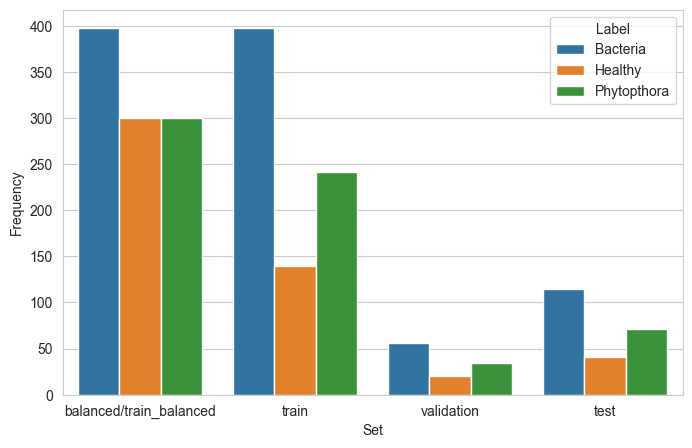

In [14]:
lst_freq = []
for folder in ['balanced/train_balanced', 'train', 'validation', 'test']:
    for label in labels:
        lst_freq.append(
            pd.Series(data={'Set': folder,
                            'Label': label,
                            'Frequency': int(len(os.listdir(my_data_dir + '/' + folder + '/' + label)))}
                      )
        )
        print(
            f"* {folder} - {label}: {len(os.listdir(my_data_dir+'/'+ folder + '/' + label))} images")
df_freq = pd.DataFrame(lst_freq)
print("\n")
sns.set_style("whitegrid")
plt.figure(figsize=(8, 5))
sns.barplot(data=df_freq, x='Set', y='Frequency', hue='Label')
plt.savefig(f'{file_path}/labels_distribution_balanced.png',
            bbox_inches='tight', dpi=150)
plt.show()

---

# Image data augmentation

---

### ImageDataGenerator

In [15]:
augmented_image_data = ImageDataGenerator(rotation_range=10,
                                          width_shift_range=0.1,      
                                          height_shift_range=0.1,   
                                          zoom_range=0.1,
                                          horizontal_flip=True,
                                          vertical_flip=True,
                                          fill_mode='nearest',
                                          rescale=1./255
                                          )

* ### Augment training image dataset

In [16]:
batch_size = 64  # Set batch size
train_set = augmented_image_data.flow_from_directory(train_balanced_path,
                                                     target_size=image_shape[:2],
                                                     color_mode='rgb',
                                                     batch_size=batch_size,
                                                     class_mode='categorical',
                                                     shuffle=True,
                                                     seed=42
                                                     )

train_set.class_indices

Found 998 images belonging to 3 classes.


{'Bacteria': 0, 'Healthy': 1, 'Phytopthora': 2}

* ### Augment validation image dataset

In [17]:
validation_set = ImageDataGenerator(rescale=1./255).flow_from_directory(val_path,
                                                                        target_size=image_shape[:2],
                                                                        color_mode='rgb',
                                                                        batch_size=batch_size,
                                                                        class_mode='categorical',
                                                                        shuffle=True,
                                                                        seed=42
                                                                        )

validation_set.class_indices

Found 110 images belonging to 3 classes.


{'Bacteria': 0, 'Healthy': 1, 'Phytopthora': 2}

* ### Augment test image dataset

In [18]:
test_set = ImageDataGenerator(rescale=1./255).flow_from_directory(test_path,
                                                                  target_size=image_shape[:2],
                                                                  color_mode='rgb',
                                                                  batch_size=batch_size,
                                                                  class_mode='categorical',
                                                                  shuffle=False
                                                                  )

test_set.class_indices

Found 227 images belonging to 3 classes.


{'Bacteria': 0, 'Healthy': 1, 'Phytopthora': 2}

## Plot augmented training image

(64, 300, 300, 3)
(64, 3)


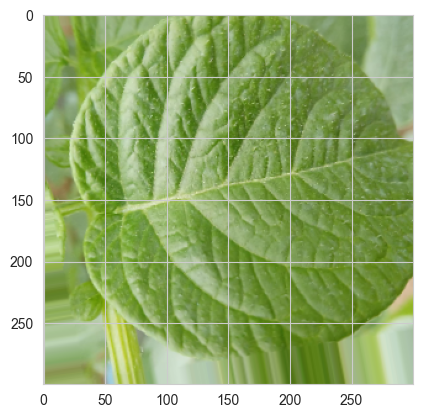

(64, 300, 300, 3)
(64, 3)


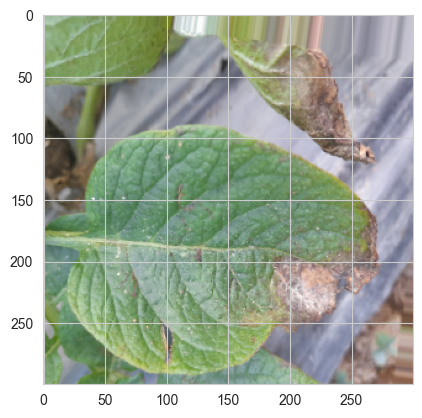

(64, 300, 300, 3)
(64, 3)


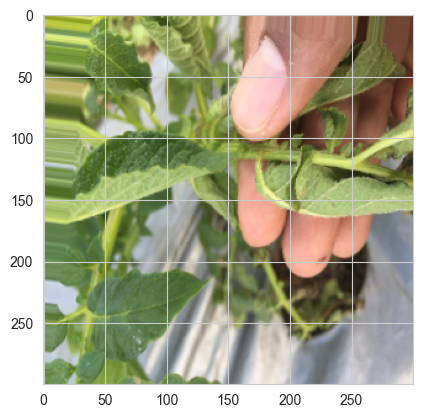

In [19]:
for _ in range(3):
    img, label = next(train_set)
    print(img.shape)  # (1,1500,1500,3)
    print(label.shape)  # (1,5)
    plt.imshow(img[0])
    plt.show()


## Plot augmented validation and test images

(64, 300, 300, 3)
(64, 3)


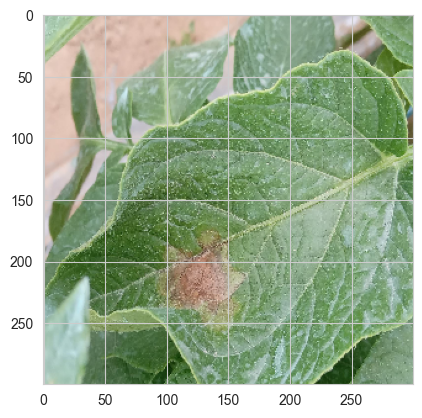

(46, 300, 300, 3)
(46, 3)


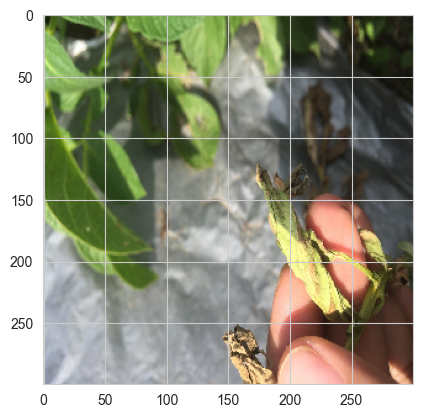

(64, 300, 300, 3)
(64, 3)


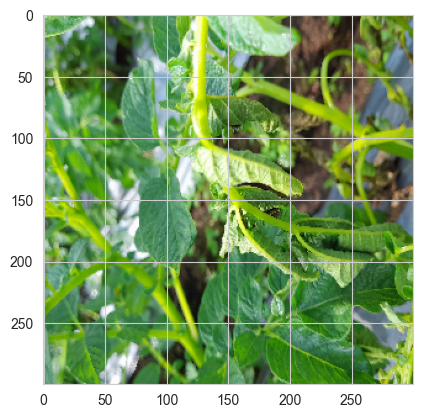

In [20]:
for _ in range(3):
    img, label = next(validation_set)
    print(img.shape)  # (1,1500,1500,3)
    print(label.shape)
    plt.imshow(img[0])
    plt.show()


(64, 300, 300, 3)
(64, 3)


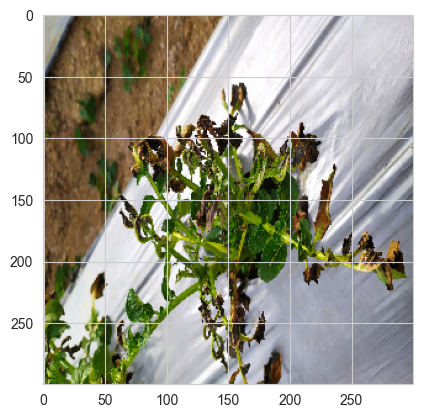

(64, 300, 300, 3)
(64, 3)


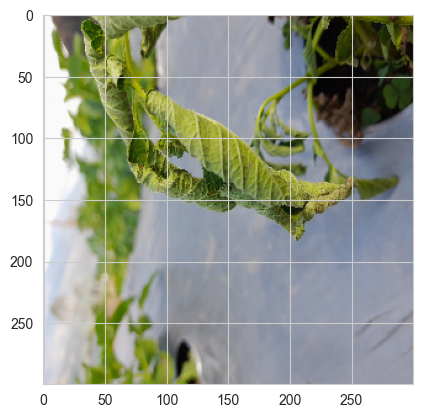

(64, 300, 300, 3)
(64, 3)


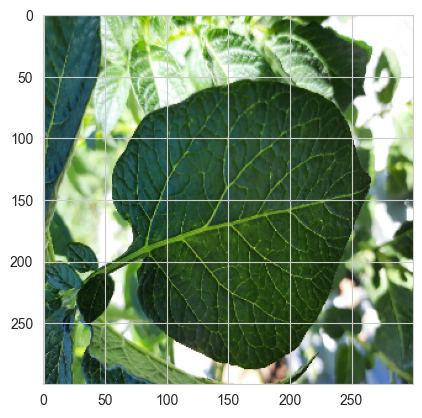

In [21]:
for _ in range(3):
    img, label = next(test_set)
    print(img.shape)  # (1,1500,1500,3)
    print(label.shape)
    plt.imshow(img[0])
    plt.show()


## Save class_indices

In [22]:
joblib.dump(value=train_set.class_indices,
            filename=f"{file_path}/class_indices.pkl")


['outputs/v1/class_indices.pkl']

---

# Model creation

---

## ML model

* ### Import model packages

In [23]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras import Input

* ### Model 

In [24]:
def create_tf_model(input_shape):
    model = Sequential()

    model.add(Input(shape=input_shape))
    
    model.add(Conv2D(filters=32, kernel_size=(3, 3), strides= (2, 2), activation='relu', ))
    
    model.add(Conv2D(filters=64, kernel_size=(3, 3), strides= (2, 2), activation='relu', ))

    model.add(Conv2D(filters=128, kernel_size=(3, 3), strides= (2, 2), activation='relu', ))

    model.add(Conv2D(filters=256, kernel_size=(3, 3), strides= (2, 2), activation='relu', ))
    
    model.add(Flatten())

    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))

    model.add(Dense(len(train_set.class_indices), activation='softmax'))

    model.compile(loss='categorical_crossentropy',
                  optimizer=Adam(),
                  metrics=['accuracy'])

    return model


* ### Model Summary 

In [25]:
input_shape = image_shape
create_tf_model(input_shape=input_shape).summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 149, 149, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 74, 74, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 36, 36, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 17, 17, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 73984)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    37,880,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │         1,539 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,270,275 (145.99 MB)

 Trainable params: 38,270,275 (145.99 MB)

 Non-trainable params: 0 (0.00 B)

* ### Early Stopping 

In [26]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=25, restore_best_weights=True)

## Fit model for model training

In [27]:
model = create_tf_model(input_shape=input_shape)
model.fit(train_set,
          epochs=300,
          validation_data=validation_set,
          callbacks=[early_stop],
          verbose=1          
          )


c:\Users\jules\anaconda3\envs\potatoes\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/300
16/16 ━━━━━━━━━━━━━━━━━━━━ 42s 3s/step - accuracy: 0.3438 - loss: 2.3114 - val_accuracy: 0.5273 - val_loss: 1.0146
Epoch 2/300
16/16 ━━━━━━━━━━━━━━━━━━━━ 33s 2s/step - accuracy: 0.4602 - loss: 1.0244 - val_accuracy: 0.3909 - val_loss: 1.0708
Epoch 3/300
16/16 ━━━━━━━━━━━━━━━━━━━━ 33s 2s/step - accuracy: 0.5240 - loss: 0.9457 - val_accuracy: 0.6182 - val_loss: 0.8049
Epoch 4/300
16/16 ━━━━━━━━━━━━━━━━━━━━ 33s 2s/step - accuracy: 0.6265 - loss: 0.8339 - val_accuracy: 0.5909 - val_loss: 0.8797
Epoch 5/300
16/16 ━━━━━━━━━━━━━━━━━━━━ 35s 2s/step - accuracy: 0.7014 - loss: 0.7072 - val_accuracy: 0.6273 - val_loss: 0.8381
Epoch 6/300
16/16 ━━━━━━━━━━━━━━━━━━━━ 33s 2s/step - accuracy: 0.7044 - loss: 0.7231 - val_accuracy: 0.6364 - val_loss: 0.8300
Epoch 7/300
16/16 ━━━━━━━━━━━━━━━━━━━━ 33s 2s/step - accuracy: 0.7587 - loss: 0.6073 - val_accuracy: 0.7000 - val_loss: 0.7103
Epoch 8/300
16/16 ━━━━━━━━━━━━━━━━━━━━ 33s 2s/step - accuracy: 0.7670 - loss: 0.5909 - val_accuracy: 0.6273 - v

## Save model

In [28]:
modelversion = 2
model_file_path = f'{file_path}/model_V{modelversion}'
if f'model_V{modelversion}' in os.listdir(work_dir + '/' + file_path):
    print('Old version is already available createing a new version.')
    while f'model_V{modelversion}' in os.listdir(work_dir + '/' + file_path):
        modelversion += 1
        model_file_path = f'{file_path}/model_V{modelversion}'

os.makedirs(name=model_file_path)
model.save(f'{model_file_path}/disease_identification_model.keras')

---

# Model Performace

---

## Model learning curve

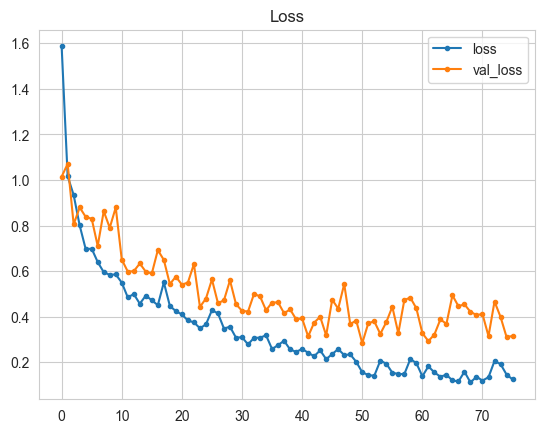

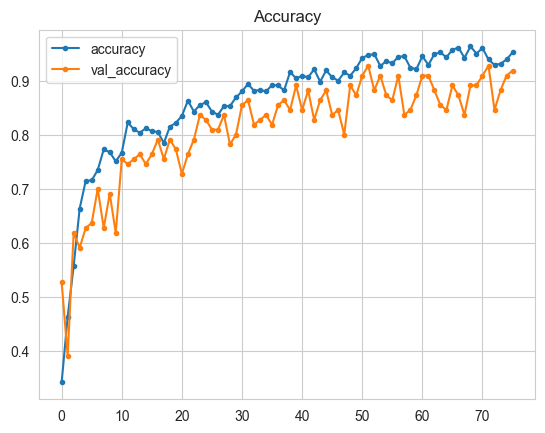

In [29]:
losses = pd.DataFrame(model.history.history)

sns.set_style("whitegrid")
losses[['loss', 'val_loss']].plot(style='.-')
plt.title("Loss")
plt.savefig(f'{model_file_path}/model_training_losses.png',
            bbox_inches='tight', dpi=150)
plt.show()

print("\n")
losses[['accuracy', 'val_accuracy']].plot(style='.-')
plt.title("Accuracy")
plt.savefig(f'{model_file_path}/model_training_acc.png',
            bbox_inches='tight', dpi=150)
plt.show()


## Model Evaluation

Load saved model

In [30]:
from keras.models import load_model
model = load_model(f'{model_file_path}/disease_identification_model.keras')

Evaluate model on test set

In [31]:
evaluation = model.evaluate(test_set)


c:\Users\jules\anaconda3\envs\potatoes\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 666ms/step - accuracy: 0.9172 - loss: 0.2026


### Save evaluation pickle

In [32]:
joblib.dump(value=evaluation,
            filename=f'{model_file_path}/evaluation.pkl')


['outputs/v1/model_V2/evaluation.pkl']

## Predict on new data

Load a random image as PIL

Image shape: (300, 300), Image mode: RGB


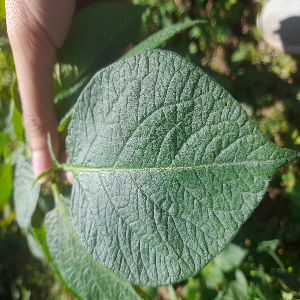

In [33]:
from tensorflow.keras.preprocessing import image

pointer = 5
label = labels[1]

pil_image = image.load_img(test_path + '/' + label + '/' + os.listdir(test_path+'/' + label)[pointer],
                           target_size=image_shape, color_mode='rgb')
print(f'Image shape: {pil_image.size}, Image mode: {pil_image.mode}')
pil_image


Convert image to array and prepare for prediction

In [34]:
my_image = image.img_to_array(pil_image)
my_image = np.expand_dims(my_image, axis=0)/255
print(my_image.shape)

(1, 300, 300, 3)


Predict class probabilities

In [35]:
pred_proba = model.predict(my_image)[0]

target_map = {v: k for k, v in train_set.class_indices.items()}
pred_class_index = np.argmax(pred_proba)
pred_class = target_map[pred_class_index]

print(f'Probabilities: {pred_proba}')
print(f'Predicted probability: {pred_proba[pred_class_index]}')
print(f'Predicted class: {pred_class}')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
Probabilities: [1.4943209e-05 9.9011582e-01 9.8692141e-03]
Predicted probability: 0.9901158213615417
Predicted class: Healthy


### Confusion Matrices

In [36]:
from sklearn.metrics import classification_report, confusion_matrix

def confusion_matrix_and_report(path,pipeline,label_map):
  # the prediction comes in a one hot encoded format
  labels = len(os.listdir(path))
  batch_size = 0
  for label in label_map:
    batch_size += len(os.listdir(path + '/' + label))
  set = ImageDataGenerator(rescale=1./255).flow_from_directory(path, target_size=image_shape[:2],
                                                                  color_mode='rgb',
                                                                  batch_size=batch_size,
                                                                  class_mode='categorical',
                                                                  shuffle=False
                                                              )
  X, y = next(set)
  prediction = pipeline.predict(X)
  # so we take the index from the highest probability, which is the "winner" or predicted class
  prediction = np.argmax(prediction, axis=1)
  
  # we also take the index from the highest probability from the actual values
  y = np.argmax(y, axis=1)

  print('---  Confusion Matrix  ---')
  print(pd.DataFrame(confusion_matrix(y_true=prediction, y_pred=y),
        columns=[ ["Actual " + sub for sub in label_map] ], 
        index= [ ["Prediction " + sub for sub in label_map ]]
        ))
  print("\n")

  print('---  Classification Report  ---')
  print(classification_report(y, prediction, target_names=label_map),"\n")


def clf_performance(train_balanced_path, test_path, validation_path,pipeline,label_map):

  print("#### Train Set #### \n")
  confusion_matrix_and_report(train_balanced_path,pipeline,label_map)

  print("#### Validation Set #### \n")
  confusion_matrix_and_report(test_path,pipeline,label_map)

  print("#### Test Set ####\n")
  confusion_matrix_and_report(validation_path,pipeline,label_map)

In [37]:
label_map = [str(x) for x in train_set.class_indices.keys()]

clf_performance(train_balanced_path, test_path, val_path, model, label_map)

#### Train Set #### 

Found 998 images belonging to 3 classes.
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step
---  Confusion Matrix  ---
                       Actual Bacteria Actual Healthy Actual Phytopthora
Prediction Bacteria                389              0                  5
Prediction Healthy                   4            295                  5
Prediction Phytopthora               5              5                290


---  Classification Report  ---
              precision    recall  f1-score   support

    Bacteria       0.99      0.98      0.98       398
     Healthy       0.97      0.98      0.98       300
 Phytopthora       0.97      0.97      0.97       300

    accuracy                           0.98       998
   macro avg       0.97      0.98      0.98       998
weighted avg       0.98      0.98      0.98       998
 

#### Validation Set #### 

Found 227 images belonging to 3 classes.
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step
---  Confusion Matrix  ---
                       Actua

---